In [1]:
#!/usr/bin/python3
import os
import sys
import argparse
import pdb
import h5py

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import numpy as np
from collections import defaultdict
import ast
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import checking_tool
import process_data
import model_zoo
import importlib
importlib.reload(checking_tool)
importlib.reload(process_data)
importlib.reload(model_zoo)

%load_ext autotime


# Compute the rank of the real key for a give set of predictions
def rank(predictions, plaintext_list, real_key, min_trace_idx, max_trace_idx, last_key_bytes_proba, target_byte):
    # Compute the rank
    if len(last_key_bytes_proba) == 0:
        # If this is the first rank we compute, initialize all the estimates to zero
        key_bytes_proba = np.zeros(256)
    else:
        # This is not the first rank we compute: we optimize things by using the
        # previous computations to save time!
        key_bytes_proba = last_key_bytes_proba

    for p in range(0, max_trace_idx-min_trace_idx):
        # Go back from the class to the key byte. '2' is the index of the byte (third byte) of interest.
        plaintext = plaintext_list[p][target_byte]
        for i in range(0, 256):
            # Our candidate key byte probability is the sum of the predictions logs
            # AES_Sbox[plaintext ^ i]
            tmp_label = process_data.aes_internal(plaintext, i)
            proba = predictions[p][tmp_label]
            if proba != 0:
                key_bytes_proba[i] += np.log(proba)
            else:
                # We do not want an -inf here, put a very small epsilon
                # that corresponds to a power of our min non zero proba
                min_proba_predictions = predictions[p][np.array(predictions[p]) != 0]
                if len(min_proba_predictions) == 0:
                    print("Error: got a prediction with only zeroes ... this should not happen!")
                    sys.exit(-1)
                min_proba = min(min_proba_predictions)
                key_bytes_proba[i] += np.log(min_proba**2)
                '''
                min_proba = 0.000000000000000000000000000000000001
                key_bytes_proba[i] += np.log(min_proba**2)
                '''

    # Now we find where our real key candidate lies in the estimation.
    # We do this by sorting our estimates and find the rank in the sorted array.
    sorted_proba = np.array(list(map(lambda a : key_bytes_proba[a], key_bytes_proba.argsort()[::-1])))
    real_key_rank = np.where(sorted_proba == key_bytes_proba[real_key])[0][0]
    return (real_key_rank, key_bytes_proba)


def full_ranks(model, dataset, key, plaintext_attack, min_trace_idx, max_trace_idx, target_byte, rank_step):
    # Real key byte value that we will use. '2' is the index of the byte (third byte) of interest.
    real_key = key[target_byte]
    # Check for overflow
    if max_trace_idx > dataset.shape[0]:
        raise ValueError("Error: asked trace index %d overflows the total traces number %d" % (max_trace_idx, dataset.shape[0]))

    # Get the input layer shape
    input_layer_shape = model.get_layer(index=0).input_shape
    if isinstance(input_layer_shape, list):
        input_layer_shape = input_layer_shape[0]
    # Sanity check
    if input_layer_shape[1] != dataset.shape[1]:
        raise ValueError("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(dataset[0, :])))

    # Adapt the data shape according our model input
    if len(input_layer_shape) == 2:
        print('# This is a MLP')
        input_data = dataset[min_trace_idx:max_trace_idx, :]
    elif len(input_layer_shape) == 3:
        print('# This is a CNN: reshape the data')
        input_data = dataset[min_trace_idx:max_trace_idx, :]
        input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
    else:
        raise ValueError("Error: model input shape length %d is not expected ..." % len(input_layer_shape))

    # Predict our probabilities
    predictions = model.predict(input_data, batch_size=200, verbose=0)

    index = np.arange(min_trace_idx+rank_step, max_trace_idx, rank_step)
    f_ranks = np.zeros((len(index), 2), dtype=np.uint32)
    key_bytes_proba = []
    for t, i in zip(index, range(0, len(index))):
        real_key_rank, key_bytes_proba = rank(predictions[t-rank_step:t], plaintext_attack[t-rank_step:t], real_key, t-rank_step, t, key_bytes_proba, target_byte)
        f_ranks[i] = [t - min_trace_idx, real_key_rank]
    return f_ranks


def get_the_labels(textins, key, target_byte):
    labels = []
    for i in range(textins.shape[0]):
        text_i = textins[i]
        label = process_data.aes_internal(text_i[target_byte], key[target_byte])
        labels.append(label)

    labels = np.array(labels)
    return labels


def load_data(opts,data_type=None):
    # checking_tool.check_file_exists(ascad_database_file)
    # in_file = h5py.File(ascad_database_file, "r")
    target_byte = opts['target_byte']
    network_type = opts['network_type']
    if not data_type or data_type=='test_source':
        val_data_path = opts['test_source']
    elif data_type == 'test_target':
        val_data_path = opts['test_target'] # load assigned data
    elif data_type == 'train_source':
        val_data_path = opts['train_source'] # load assigned data
    else:
        print(f"data type choice [test_target,train_source, test_source]")
    
    shifted = opts['shifted']
    if not os.path.isfile(val_data_path):
        raise ValueError('file did not find: {}'.format(val_data_path))
    clsNum = 9 if 'hw_model' == network_type else 256
    val_data_whole_pack = np.load(val_data_path)

    attack_window = opts['attack_window']
    if attack_window:
        tmp = opts['attack_window'].split('_')
        start_idx, end_idx = int(tmp[0]), int(tmp[1])
        attack_window = [start_idx, end_idx]

    if shifted:
        print('data will be shifted in range: ', [0, shifted])
        traces, labels, text_in, key, inp_shape = process_data.process_raw_data_shifted(val_data_whole_pack, target_byte, network_type, shifted, attack_window)
    else:
        traces, labels, text_in, key, inp_shape = process_data.process_raw_data(val_data_whole_pack, target_byte, network_type, attack_window)

    labels = to_categorical(labels, clsNum)
    return traces, labels, text_in, key, inp_shape


def plot_figure(x, y, model_file_name, dataset_name, fig_save_name, testType):
    plt.title('Performance of ' + model_file_name + ' against ' + dataset_name + ' testType ' + testType)
    plt.xlabel('number of traces')
    plt.ylabel('rank')
    plt.grid(True)
    plt.plot(x, y)
    plt.savefig(fig_save_name)
    plt.show(block=False)
    plt.figure()


# Check a saved model against one of the testing databases Attack traces
def main(opts):
    # checking model file existence
    model_file = opts['model_file']

    # Load model
    model = checking_tool.load_best_model(model_file)
#     model.summary()

    # Load profiling and attack data and metadata from the ASCAD database
    # val_traces, val_label, val_textin, key
    X_attack, Y_attack, plaintext_attack, key, inp_shape = load_data(opts)

    '''
    print('shuffle the data and then calculate the rank')
    X_attack, Y_attack, plaintext_attack = loadData.shuffleData(X_attack, Y_attack, plaintext_attack)
    print('shuffle data has been done!')
    '''

    # Get the input layer shape
    input_layer_shape = model.get_layer(index=0).input_shape
    if isinstance(input_layer_shape, list):
        input_layer_shape = input_layer_shape[0]

    # Sanity check
    Reshaped_X_attack = process_data.sanity_check(input_layer_shape, X_attack)

    # run the accuracy test
    score, acc = model.evaluate(Reshaped_X_attack, Y_attack, verbose=opts['verbose'])
    print('test acc is: {:f}'.format(acc))

    # We test the rank over traces of the Attack dataset, with a step of 10 traces
    print('start computing rank value...')
    min_trace_idx = 0
    max_trace_idx = 2000
    rank_step = 1
    target_byte = opts['target_byte']
    ranks = full_ranks(model, X_attack, key, plaintext_attack, min_trace_idx, max_trace_idx, target_byte, rank_step)

    # We plot the results
    # f_ranks[i] = [t, real_key_rank]
    x = [ranks[i][0] for i in range(0, ranks.shape[0])]
    y = [ranks[i][1] for i in range(0, ranks.shape[0])]

    dataset_name = os.path.basename(opts['input'])
    os.makedirs(opts['output'], exist_ok=True)
    testType = os.path.basename(opts['input']).split('.')[0]
    testType = testType.split('_')[1]
    device_name = os.path.basename(os.path.dirname(opts['input']))
    fig_save_dir = os.path.join(opts['output'], device_name, opts['network_type'])
    os.makedirs(fig_save_dir, exist_ok=True)
    fig_save_name = os.path.join(fig_save_dir, str(dataset_name) + '_rank_performance_byte_{}_{}.png'.format(target_byte, testType))
    print('figure save to file: {}'.format(fig_save_name))
    model_file_name = os.path.basename(model_file).split('.')[0]

    # def plot_figure(x, y, model_file_name, dataset_name, fig_save_name):
    plot_figure(x, y, model_file_name, dataset_name, fig_save_name, testType)

    test_summary_path = 'test_summary.txt'
    contents = '{} --- {} --- {:f}\n\n'.format(opts['input'], opts['network_type'], acc)
    with open(test_summary_path, 'a') as f:
        f.write(contents)
    
    return model

Instructions for updating:
non-resource variables are not supported in the long term


## Parameters and run

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
loading pre-trained model...


2022-06-17 11:01:46.926856: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 11:01:46.970491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 11:01:47.020569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 11:01:47.021166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

use the self-defined attack window


/home/uc_sec/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-06-17 11:01:50.447600: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-06-17 11:01:50.829190: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


test acc is: 0.657225
start computing rank value...
# This is a CNN: reshape the data


/home/uc_sec/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


figure save to file: ./test_results/unmasked_xmega_cnn/device01/cnn2/PC1_CB1_TDX1_K0_U_20k_0317.npz_rank_performance_byte_0_CB1.png


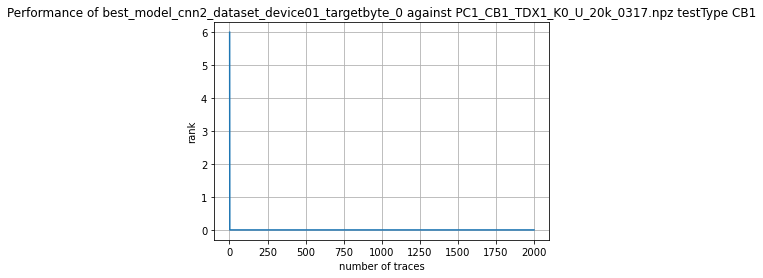

<Figure size 432x288 with 0 Axes>

time: 14.5 s


In [2]:
opts = {
    "test_source": '../../XMEGA/our_data/unmasked/device01/PC1_CB1_TDX1_K0_U_20k_0317.npz', # test data from device1
    "test_target": '../../XMEGA/our_data/unmasked/device02/PC2_CB2_TDX3_K3_U_20k_0317.npz',
    "train_source": '../../XMEGA/our_data/unmasked/device01/PC1_CB1_TDX1_K0_U_200k_0317.npz',
    "output": './test_results/unmasked_xmega_cnn',
    "model_file": "./trained_model/unmasked_xmega_cnn.h5/cnn2_dir/best_model_cnn2_dataset_device01_targetbyte_0.hdf5",
    "verbose": 'store_true',
    "target_byte": 0,
    "network_type": 'cnn2',
    "shifted": 0,
    "attack_window": '1800_2800'
}
opts['input'] = opts['test_source']

if tf.test.is_gpu_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"


## start run test function
model = main(opts)

## Define background and explainer

In [3]:
## load source training data (device01)
X_attack_source, Y_attack_source, _, _,_ = load_data(opts,data_type='test_source')
X_attack_target, Y_attack_target,_,_,_ = load_data(opts,data_type='test_target')
X_train_source, Y_train_source, _, _,_ = load_data(opts,data_type='train_source')


use the self-defined attack window
use the self-defined attack window
use the self-defined attack window
time: 6.96 s


In [4]:
import numpy as np
import shap

## select a set of training data as background examples, which use them as expectation value (base value)
num_background_data = 100
background = X_train_source[np.random.choice(X_train_source.shape[0],num_background_data,replace=False)] # replace=False means a value can only be choose once
print(f"shape of background numpy data {background.shape}")

## reshape data for 'cnn2'
input_layer_shape = model.get_layer(index=0).input_shape
if isinstance(input_layer_shape, list):
    input_layer_shape = input_layer_shape[0]
background = process_data.sanity_check(input_layer_shape, background)
print(f"shape of reshaped data {background.shape}")


## define and get explainer 
e = shap.DeepExplainer(model,background)

/home/uc_sec/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


shape of background numpy data (100, 1000)
shape of reshaped data (100, 1000, 1)

time: 835 ms


## Same-Device: training and testing data from same device (follow same distribution)

In [5]:
# get test sample randomly
test_sample = X_attack_source[np.random.choice(X_attack_source.shape[0],1,replace=False)]
print(f"shape of test sample numpy data {test_sample.shape}")
test_sample_tensor = np.expand_dims(test_sample,axis=2).astype(np.float32)
print(f"shape of reshaped test sample data {test_sample_tensor.shape}")

# shapley value
shap_values = e.shap_values(test_sample_tensor)
print(f"shap_values shape {np.array(shap_values).shape}")
shap_values = np.squeeze(np.array(shap_values))

## visualize results based on positive and negative values
"""
## e.expected_value: the mean prediction of model in terms of background data, 
where index 0 is the expected value for the predicted class with highest score based on background data
## shap_values.shape=[num_class,batch_size,1,size_of_each_sample]
## shap_values[0]--> index at 0 is the predicted label with highest score
"""
shap.initjs() # init the JS visualization code
shap.force_plot(e.expected_value[0], shap_values[0], test_sample) # expected_value[0] --> the first expected value --> match for the first test sample/shap_value

shape of test sample numpy data (1, 1000)
shape of reshaped test sample data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)


time: 4min 23s


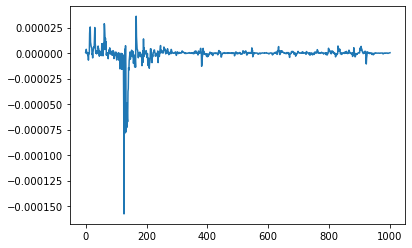

time: 65.2 ms


In [6]:
import matplotlib.pyplot as plt

## visualize reuslts global
x=np.linspace(0,len(shap_values[0]),len(shap_values[0]),dtype=int)
plt.plot(x,shap_values[0])
plt.show()

(1000,)
(1, 1000)


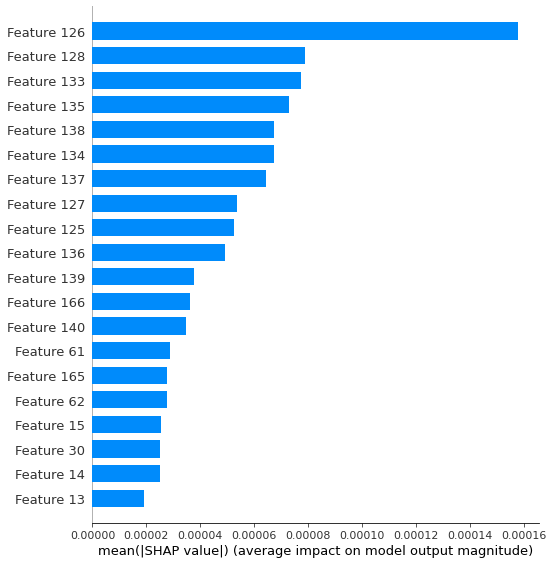

time: 130 ms


In [7]:
## plot the abs value of shap values of each feature
## however, we can not tell whether the feature with highest value has a positive effect or negative effect 
## as this plot take the absolute shapley value for each feature, 

print(shap_values[0].shape)
print(test_sample.shape)
shap.summary_plot(np.expand_dims(shap_values[0],axis=0), test_sample, plot_type="bar")

### Get shapley values for mutiple test sample and save results in path 

shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample n

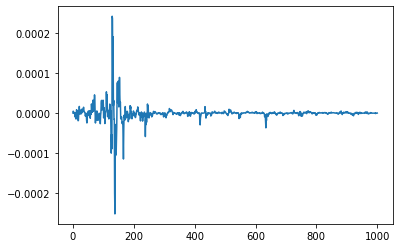

time: 1min 3s


In [8]:
## get shapley values for mutiple test sample and save results in path 
from pathlib import Path
import matplotlib.pyplot as plt 
import pandas as pd
import copy

## define number of test
num_test = 1000
seperate_plot = False

## define folder to save results
Path(f"./results/explain_ai/keras/").mkdir(parents=True,exist_ok=True)

## define figure plot and save function
def shap_values_plot(x=None,y=None,output_file=None,y_limit=False):
    if x == None:
        x=np.linspace(0,len(y),len(y),dtype=int)
    plt.plot(x,y)
    if y_limit:
        plt.ylim(-10,10)
    plt.savefig(f"./results/explain_ai/keras/{output_file}")
    print(f"results save in './results/explain_ai/keras/{output_file}'")
    plt.show()

## get test results
shap_values_sum = np.zeros(X_attack_source.shape[-1])
for i in range(num_test):
    # get test sample randomly
    test_sample = X_attack_source[np.random.choice(X_attack_source.shape[0],1,replace=False)]
    print(f"shape of test sample numpy data {test_sample.shape}")
    test_sample_tensor = np.expand_dims(test_sample,axis=2).astype(np.float32)
    print(f"shape of test sample tensor data {test_sample_tensor.shape}")
    
    # shapley value
    shap_values = e.shap_values(test_sample_tensor)
    print(f"shap_values shape {np.array(shap_values).shape}")
    shap_values = np.squeeze(np.array(shap_values))
    print(f"squeezed shap_values shape {np.array(shap_values).shape}")
    shap_values_sum += shap_values[0]
    
    # visualize results
    #shap.force_plot(e.expected_value[0], shap_values[0][0], test_sample) # expected_value[0] --> the first expected value --> match for the first test sample/shap_value
    if seperate_plot:
        output_file = f"model_pred_explaination_same_device_{i}.png"
        print(f"visual shape {shap_values[0].shape}")
        shap_values_plot(y=shap_values[0],output_file=output_file)
    
## get the average shapley values and plot
shap_values_avg = shap_values_sum / num_test
shap_values_avg_df = pd.DataFrame(shap_values_avg)
shap_values_avg_df.to_csv('./results/explain_ai/keras/avg_shapley_values_same_device.csv',index=False)
shap_values_plot(y=shap_values_avg,output_file='model_pred_explaination_same_device_avg.png',y_limit=False)
shap_values_same_device = copy.deepcopy(shap_values_avg)

## Cross-Device: training and testing data from different device (following different distribution)

### Get shapley values for a single test sample 

In [9]:
# get test sample randomly
test_sample = X_attack_target[np.random.choice(X_attack_target.shape[0],1,replace=False)]
print(f"shape of test sample numpy data {test_sample.shape}")
test_sample_tensor = np.expand_dims(test_sample,axis=2).astype(np.float32)
print(f"shape of test sample tensor data {test_sample_tensor.shape}")

# shapley value
shap_values = e.shap_values(test_sample_tensor)
print(f"shap_values shape {np.array(shap_values).shape}")
shap_values = np.squeeze(np.array(shap_values))
print(f"squeezed shap_values shape {np.array(shap_values).shape}")

## visualize results based on positive and negative values
"""
## e.expected_value: the mean prediction of model in terms of background data, 
where index 0 is the expected value for the predicted class with highest score based on background data
## shap_values.shape=[num_class,batch_size,1,size_of_each_sample]
## shap_values[0]--> index at 0 is the predicted label with highest score
"""
shap.initjs() # init the JS visualization code
shap.force_plot(e.expected_value[0], shap_values[0], test_sample) # expected_value[0] --> the first expected value --> match for the first test sample/shap_value

shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)


time: 6.42 s


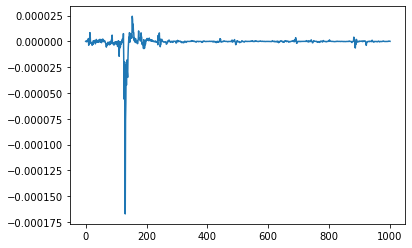

time: 64.8 ms


In [10]:
import matplotlib.pyplot as plt

## visualize reuslts global
x=np.linspace(0,len(shap_values[0]),len(shap_values[0]),dtype=int)
plt.plot(x,shap_values[0])
plt.show()

(1000,)
(1, 1000)


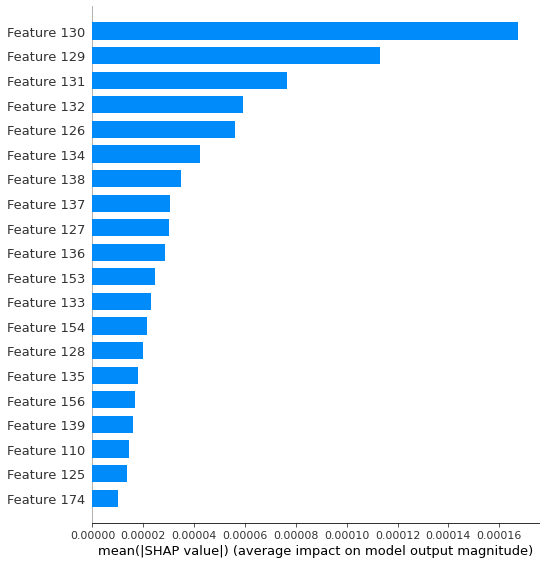

time: 114 ms


In [11]:
## plot the abs value of shap values of each feature
## however, we can not tell whether the feature with highest value has a positive effect or negative effect 
## as this plot take the absolute shapley value for each feature, 

print(shap_values[0].shape)
print(test_sample.shape)
shap.summary_plot(np.expand_dims(shap_values[0],axis=0), test_sample, plot_type="bar")

### Get shapley values for mutiple test sample and save results in path 

shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data (1, 1000, 1)
shap_values shape (256, 1, 1000, 1)
squeezed shap_values shape (256, 1000)
shape of test sample n

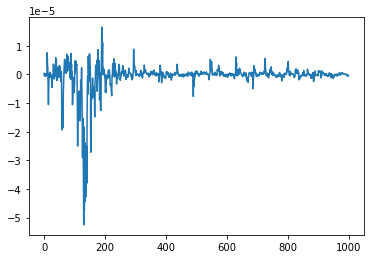

time: 1min 4s


In [12]:
## get shapley values for mutiple test sample and save results in path 
from pathlib import Path
import matplotlib.pyplot as plt 
import copy 
import pandas as pd

## define number of test
num_test = 1000
seperate_plot = False

## define folder to save results
Path(f"./results/explain_ai/keras/").mkdir(parents=True,exist_ok=True)

## define figure plot and save function
def shap_values_plot(x=None,y=None,output_file=None,y_limit=False):
    if x == None:
        x=np.linspace(0,len(y),len(y),dtype=int)
    plt.plot(x,y)
    if y_limit:
        plt.ylim(-10,10)
    plt.savefig(f"./results/explain_ai/keras/{output_file}")
    print(f"results save in './results/explain_ai/keras/{output_file}'")
    plt.show()

## get test results
shap_values_sum = np.zeros(X_attack_source.shape[-1])
for i in range(num_test):
    # get test sample randomly
    test_sample = X_attack_target[np.random.choice(X_attack_target.shape[0],1,replace=False)]
    print(f"shape of test sample numpy data {test_sample.shape}")
    test_sample_tensor = np.expand_dims(test_sample,axis=2).astype(np.float32)
    print(f"shape of test sample tensor data {test_sample_tensor.shape}")
    
    # shapley value
    shap_values = e.shap_values(test_sample_tensor)
    print(f"shap_values shape {np.array(shap_values).shape}")
    shap_values = np.squeeze(np.array(shap_values))
    print(f"squeezed shap_values shape {np.array(shap_values).shape}")
    
    shap_values_sum += shap_values[0]
    
    # visualize results
    #shap.force_plot(e.expected_value[0], shap_values[0][0], test_sample) # expected_value[0] --> the first expected value --> match for the first test sample/shap_value
    if seperate_plot:
        output_file = f"model_pred_explaination_cross_device_{i}.png"
        print(f"visual shape {shap_values[0].shape}")
        shap_values_plot(y=shap_values[0],output_file=output_file)
    
## get the average shapley values and plot
shap_values_avg = shap_values_sum / num_test
shap_values_avg_df = pd.DataFrame(shap_values_avg)
shap_values_avg_df.to_csv('./results/explain_ai/keras/avg_shapley_values_cross_device.csv',index=False)
shap_values_plot(y=shap_values_avg,output_file='model_pred_explaination_cross_device_avg.png',y_limit=False)
shap_values_cross_device = copy.deepcopy(shap_values_avg)

#### Plot in same figure with different cases (same divice, cross device, cross device fine-tune)

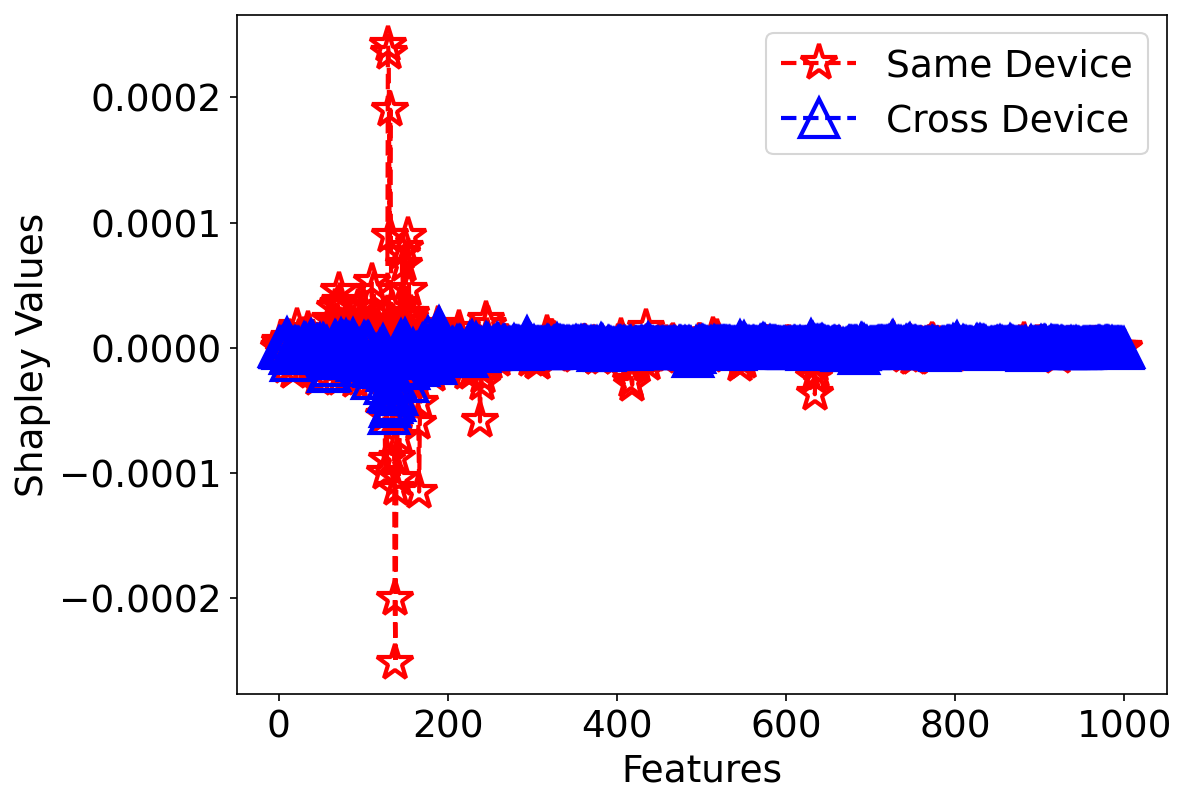

time: 205 ms


In [13]:
import numpy as np 

marker_size = 18
font_size = 18
x = np.linspace(0,len(shap_values_cross_device),len(shap_values_cross_device),dtype=int)
plt.figure(figsize=(8,6),dpi=150)
plt.plot(x, shap_values_same_device, color='red', marker='*', linestyle='--', linewidth=2, markeredgewidth=2,
         fillstyle='none', markersize=marker_size, label='Same Device')
plt.plot(x, shap_values_cross_device, color='blue', marker='^', linestyle='--', linewidth=2, markeredgewidth=2,
         fillstyle='none', markersize=marker_size, label='Cross Device')
# plt.plot(x, shap_values_cross_device_fine_tune, color='orange', marker='o', linestyle='--', linewidth=2, markeredgewidth=2,
#          fillstyle='none', markersize=marker_size, label='Cross Device Fine-Tune')
plt.xlabel('Features', {'size': font_size})
plt.ylabel('Shapley Values', {'size': font_size})
plt.tick_params(labelsize=font_size)
plt.legend(loc='best', fontsize=font_size)
plt.savefig(f"./results/explain_ai/keras/feature_importance_different_cases.png")
plt.show()